In [6]:
#import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import regex as re

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

In [2]:
path = os.getcwd()
prospects = pd.DataFrame(columns=['Rank', 'Name', 'Avg', 'Draft Year'])
for year in range(2016, 2023):
    df = pd.read_csv(os.path.join(path, f'data\\big_boards\\{year}_big_board.csv'))
    # Two players only having one ranking in the top 107 for 2018
    if year == 2018:
        df = df.drop([70, 88])
    df = df.iloc[:107]
    df['Draft Year'] = year
    df = df[['Rank', 'Name', 'SD','Avg', 'Draft Year']]
    prospects = pd.concat([prospects, df])
prospects = prospects.sort_values(by=['Rank', 'Draft Year']).reset_index(drop=True)
prospects['SD'] = pd.to_numeric(prospects['SD'])

In [12]:
vals = np.array(prospects[['SD', 'Avg']])

param_grid = {
    "n_components": range(1, 21),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(vals)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 21)},
             scoring=<function gmm_bic_score at 0x00000243AF607060>)

In [15]:
best_score = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
best_score["mean_test_score"] = -best_score["mean_test_score"]
best_score = best_score.rename(
    columns={
    "param_n_components": "Number of components",
    "param_covariance_type": "Type of covariance",
    "mean_test_score": "BIC score",
    }
)
best_score.sort_values(by="BIC score").head(20)

,Number of components,Type of covariance,BIC score
60,1,full,2836.167020
20,1,tied,2836.167020
40,1,diag,2983.846020
61,2,full,3001.328002
0,1,spherical,3086.722617
21,2,tied,3090.318018
62,3,full,3181.482795
41,2,diag,3255.569629
63,4,full,3300.067562
22,3,tied,3311.032011


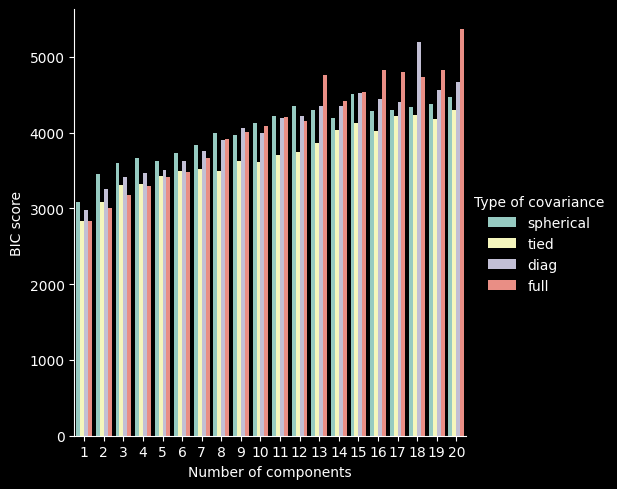

In [14]:
import seaborn as sns

sns.catplot(
    data=best_score,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [4]:
vals = np.array(prospects[['Avg']])
gm = GaussianMixture(n_components=20, random_state=32).fit(vals)
prospects['Cluster'] = gm.predict(vals)

sse = {}
for k in range(1, 21):
    gm = GaussianMixture(n_clusters=k, max_iter=1000).fit(vals)
    prospects['Cluster'] = gm.predict(vals)
    #print(data["clusters"])
    sse[k] = gm.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [53]:
cluster_order = []
for i in prospects['Cluster']:
    if i in cluster_order:
        continue
    else:
        cluster_order.append(i)
cluster_order
prospects['Cluster'] = prospects['Cluster'].apply(lambda x: cluster_order.index(x))

In [17]:
prospects.head(40)

,Rank,Name,Avg,Draft Year,Cluster
0,1,Laremy Tunsil,2.56,2016,0
1,1,Myles Garrett,1.00,2017,0
2,1,Saquon Barkley,2.67,2018,0
3,1,Nick Bosa,1.93,2019,0
4,1,Chase Young,1.31,2020,0
5,1,Trevor Lawrence,1.00,2021,0
6,1,Aidan Hutchinson,2.65,2022,0
7,2,Myles Jack,3.44,2016,0
8,2,Jamal Adams,5.22,2017,0
9,2,Quenton Nelson,3.17,2018,0


In [18]:
prospects[['Avg', 'Draft Year', 'Cluster']]

,Avg,Cluster
0,2.56,0
1,1.00,0
2,2.67,0
3,1.93,0
4,1.31,0
...,...,...
744,110.50,18
745,116.55,19
746,114.38,19
747,121.30,19


In [54]:
prospects_plot = prospects[['Rank', 'Draft Year', 'Cluster']]
prospects_plot = prospects_plot.pivot(index='Rank', columns='Draft Year', values = 'Cluster')

In [22]:
prospects_plot

Rank,1,2,3,4,5,6,7,8,9,10,...,98,99,100,101,102,103,104,105,106,107
Draft Year,,,,,,,,,,,,,,,,,,,,,
2016,0,0,0,0,0,1,1,1,1,1,...,18,19,19,19,19,19,19,19,19,19
2017,0,0,0,0,0,0,0,1,1,1,...,17,17,17,16,16,16,18,18,18,18
2018,0,0,0,0,1,1,1,1,1,1,...,16,16,16,18,18,18,18,18,18,18
2019,0,0,0,0,1,1,1,1,1,1,...,18,18,18,18,19,19,19,19,19,19
2020,0,0,0,0,0,0,1,1,1,1,...,16,16,16,18,18,18,18,18,18,19
2021,0,0,0,0,0,0,1,1,1,1,...,18,18,18,18,19,19,19,19,19,19
2022,0,0,0,0,0,0,1,1,1,1,...,16,16,16,16,18,18,18,18,18,18


<Axes: xlabel='Rank'>

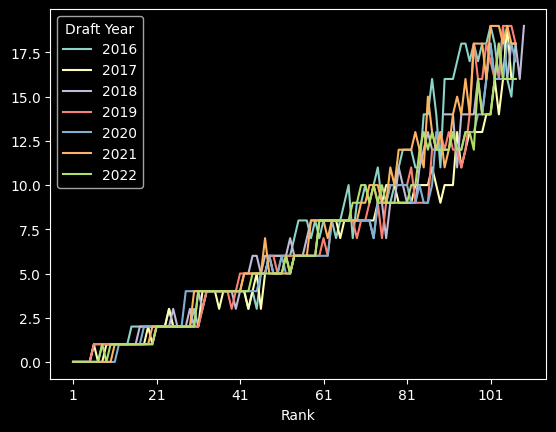

In [55]:
prospects_plot.plot()

In [56]:
df_agg = prospects.groupby(['Cluster', 'Draft Year'])['Cluster'].count()
df_agg.head(21)

Cluster  Draft Year
0        2016           5
         2017           7
         2018           7
         2019           5
         2020          11
         2021          10
         2022           8
1        2016           9
         2017          12
         2018           9
         2019          15
         2020           6
         2021           9
         2022          12
2        2016          15
         2017          11
         2018          12
         2019          11
         2020          10
         2021          10
         2022          10
Name: Cluster, dtype: int64

In [7]:
df_agg = pd.Series.to_frame(df_agg)
df_agg = df_agg.rename(columns={'Cluster': 'count'})
df_agg = df_agg.reset_index()

In [16]:
df_agg.loc[df_agg['Draft Year'] == 2017]

,Cluster,Draft Year,count
1,0,2017,7
8,1,2017,3
15,2,2017,7
22,3,2017,5
29,4,2017,7
36,5,2017,6
43,6,2017,9
50,7,2017,5
57,8,2017,5
64,9,2017,2


In [8]:
df_agg.head(40)

,Cluster,Draft Year,count
0,0,2016,5
1,0,2017,7
2,0,2018,4
3,0,2019,4
4,0,2020,6
5,0,2021,6
6,0,2022,6
7,1,2016,5
8,1,2017,3
9,1,2018,6


In [38]:
#load the data
path = os.getcwd()
#load big boards
df_2016 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2016_big_board.csv'))
df_2016 = df_2016.drop('Unnamed: 0', axis=1)
df_2016 = df_2016.loc[df_2016['Rank'] < 108]
df_2016['Draft Year'] = 2016
df_2017 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2017_big_board.csv'))
df_2017 = df_2017.drop('Unnamed: 0', axis=1)
df_2017 = df_2017.loc[df_2017['Rank'] < 108]
df_2017['Draft Year'] = 2017
df_2018 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2018_big_board.csv'))
df_2018 = df_2018.drop('Unnamed: 0', axis=1)
df_2018['Position'] = df_2018['Position'].apply(lambda x: re.sub(' .*', '', x))
df_2018 = df_2018.loc[df_2018['Rank'] < 108]
df_2018['Draft Year'] = 2018
df_2019 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2019_big_board.csv'))
df_2019 = df_2019.drop('Unnamed: 0', axis=1)
df_2019['Position'] = df_2019['Position'].apply(lambda x: re.sub(' .*', '', x))
df_2019 = df_2019.loc[df_2019['Rank'] < 108]
df_2019['Draft Year'] = 2019
df_2020 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2020_big_board.csv'))
df_2020 = df_2020.drop('Unnamed: 0', axis=1)
df_2020['Position'] = df_2020['Position'].apply(lambda x: re.sub(' .*', '', x))
df_2020 = df_2020.loc[df_2020['Rank'] < 108]
df_2020['Draft Year'] = 2020
df_2021 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2021_big_board.csv'))
df_2021 = df_2021.drop('Unnamed: 0', axis=1)
df_2021['Position'] = df_2021['Position'].apply(lambda x: re.sub(' .*', '', x))
df_2021 = df_2021.loc[df_2021['Rank'] < 108]
df_2021['Draft Year'] = 2021
df_2022 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2022_big_board.csv'))
df_2022 = df_2022.drop('Unnamed: 0', axis=1)
df_2022['Position'] = df_2022['Position'].apply(lambda x: re.sub(' .*', '', x))
df_2022 = df_2022.loc[df_2022['Rank'] < 108]
df_2022['Draft Year'] = 2022
df_2023 = pd.read_csv(os.path.join(path, 'data\\big_boards\\2023_big_board.csv'))
df_2023 = df_2023.drop('Unnamed: 0', axis=1)
df_2023['Position'] = df_2023['Position'].apply(lambda x: re.sub(' .*', '', x))
df_2023 = df_2023.loc[df_2023['Rank'] < 108]
df_2023['Draft Year'] = 2023
#load the draft value charts
df_otc = pd.read_csv(os.path.join(path, 'data\\trade_value_charts\\fitzgerald-spielberger_trade_value_chart.csv'))
#load pfr roster data
df_roster = pd.read_csv(os.path.join(path, 'data\\player_value\\pfr_av_only.csv'))

In [39]:
df_2018.iloc[65:105]

,Rank,Position,Name,BR,CBS,TDN,DT,ESPN,NBC,NFL,PFF,SI,USA,WF,Yahoo,SD,Avg,Draft Year
65,66,RB,Rashaad Penny,–,123,107,92,47,74,44,29,72,36,90,94,30.9,73.45,2018
66,67,CB,M.J. Stewart,–,66,85,70,92,77,64,70,–,69,–,76,9.2,74.33,2018
67,68,RB,Kerryon Johnson,–,74,84,74,79,86,50,107,52,104,47,61,20.5,74.36,2018
68,69,LB,Uchenna Nwosu,–,79,–,48,49,73,75,110,65,75,–,97,20.1,74.56,2018
69,70,TE,Mark Andrews,–,72,62,78,80,123,97,48,67,53,52,93,22.6,75.00,2018
70,71,OT,Brandon Packer,–,–,–,–,–,–,–,–,–,–,76,–,–,76.00,2018
71,72,WR,D.J. Chark,–,–,101,68,48,64,56,113,82,62,99,71,21.5,76.40,2018
72,73,OT,Jamarco Jones,46,81,20,191,108,70,80,32,93,85,–,73,45.3,79.91,2018
73,74,WR,Equanimeous St. Brown,–,122,108,96,139,48,65,66,75,79,37,45,32.9,80.00,2018
74,75,LB,Malik Jefferson,28,60,95,97,78,149,127,114,76,50,63,43,36.0,81.67,2018


In [12]:
vals_2016 = np.array(df_2016[['Avg']])
gm_2016 = GaussianMixture(n_components=20, random_state=32).fit(vals_2016)
gm_2016.means_

array([[101.50245005],
       [ 38.09827174],
       [ 73.99755266],
       [  7.78      ],
       [116.90206096],
       [ 54.53183596],
       [ 27.90696477],
       [ 91.90013965],
       [ 80.16428685],
       [ 16.93434724],
       [109.78279198],
       [ 66.92618443],
       [ 32.66022239],
       [ 43.78046844],
       [ 60.84302171],
       [ 12.89116743],
       [ 70.01715994],
       [ 22.29097264],
       [105.79363783],
       [  4.02200232]])

In [13]:
df_2016['Cluster'] = gm_2016.predict(vals_2016)
df_2016.head(20)

,Rank,Position,Name,BR,ESPN,NFL,PFF,SBN,SI,USA,WF,Yahoo,SD,Avg,Draft Year,Cluster
0,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,1,4,1.5,2.56,2016,19
1,2,LB,Myles Jack,2,8,2,6,4,2,4,2,1,2.3,3.44,2016,19
2,3,CB,Jalen Ramsey,1,3,8,3,3,1,3,11,3,3.3,4.00,2016,19
3,4,RB,Ezekiel Elliott,8,4,5,7,7,4,2,4,2,2.2,4.78,2016,19
4,5,ED,Joey Bosa,6,1,14,1,1,8,5,7,5,4.2,5.33,2016,19
5,6,ED,DeForest Buckner,7,6,3,2,6,6,27,3,10,7.6,7.78,2016,3
6,7,OT,Ronnie Stanley,11,5,6,16,8,5,31,12,9,8.2,11.44,2016,15
7,8,IDL,Sheldon Rankins,14,12,27,8,15,11,7,13,6,6.3,12.56,2016,15
8,9,CB,Vernon Hargreaves III,10,23,11,18,10,13,15,6,11,5.0,13.00,2016,15
9,10,QB,Jared Goff,5,11,12,4,5,14,42,15,22,11.8,14.44,2016,15


In [14]:
cluster_order = []
for i in df_2016['Cluster']:
    if i in cluster_order:
        continue
    else:
        cluster_order.append(i)
df_2016['Cluster'] = df_2016['Cluster'].apply(lambda x: cluster_order.index(x))

In [15]:
agg_2016 = df_2016.groupby(['Cluster'])['Cluster'].count()
agg_2016.head(20)

Cluster
0      5
1      1
2      4
3      3
4      4
5     10
6      5
7      8
8      5
9      5
10     4
11     4
12     4
13     3
14    12
15     7
16     5
17     5
18     4
19     9
Name: Cluster, dtype: int64

In [12]:
df_roster.head(10)

,pfr_player_id,rookie_season,year,age,tm,pos,no,g,gs,av,awards
0,AikmTr00,1989,1999,33,DAL,QB,8.0,14,14,10.0,NaN
1,AikmTr00,1989,2000,34,DAL,QB,8.0,11,11,4.0,NaN
2,BankTo00,1996,1999,26,BAL,QB,12.0,12,10,7.0,NaN
3,BankTo00,1996,2000,27,BAL,QB,12.0,11,8,5.0,NaN
4,BankTo00,1996,2001,28,WAS,QB,12.0,15,14,8.0,NaN
5,BankTo00,1996,2003,30,HOU,QB,12.0,7,3,2.0,NaN
6,BankTo00,1996,2004,31,HOU,QB,12.0,5,0,0.0,NaN
7,BankTo00,1996,2005,32,HOU,QB,12.0,2,0,1.0,NaN
8,BatcCh00,1998,1999,25,DET,QB,10.0,11,10,7.0,NaN
9,BatcCh00,1998,2000,26,DET,QB,10.0,15,15,9.0,NaN


In [59]:
df_roster.loc[df_roster.pfr_player_id.str.startswith('Tuns')]

,pfr_player_id,rookie_season,year,age,tm,pos,no,g,gs,av,awards,ID
23171,TunsLa00,2016,2016,22,MIA,LG,67.0,14,14,6.0,NaN,TunsLa2016
23172,TunsLa00,2016,2017,23,MIA,LT,67.0,15,15,6.0,NaN,TunsLa2016
23173,TunsLa00,2016,2018,24,MIA,LT,78.0,15,15,6.0,NaN,TunsLa2016
23174,TunsLa00,2016,2019,25,HOU,LT,78.0,14,14,10.0,PB,TunsLa2016
23175,TunsLa00,2016,2020,26,HOU,LT,78.0,14,14,10.0,PB,TunsLa2016
23176,TunsLa00,2016,2021,27,HOU,LT,78.0,5,5,2.0,NaN,TunsLa2016
23177,TunsLa00,2016,2022,28,HOU,OL,78.0,17,17,8.0,PB,TunsLa2016


In [55]:
df_roster['ID'] = df_roster['pfr_player_id'].str[:-2] + df_roster['rookie_season'].astype('str')

In [67]:
df_2016['First Name'] = df_2016['Name'].apply(lambda x: re.sub(' .*', '', x))
df_2016['Last Name'] = df_2016['Name'].apply(lambda x: re.sub('.* ', '', x))
df_2016['Year'] = 2016

In [61]:
df_2016['ID'] = df_2016['Last Name'].str[:4] + df_2016['First Name'].str[:2] + df_2016['Year'].astype('str')

In [63]:
df_test = df_2016.merge(df_roster, how = 'left', on = 'ID')

In [64]:
df_test.head(20)

,Rank,Position,Name,BR,ESPN,NFL,PFF,SBN,SI,USA,...,rookie_season,year,age,tm,pos,no,g,gs,av,awards
0,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2016.0,22.0,MIA,LG,67.0,14.0,14.0,6.0,NaN
1,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2017.0,23.0,MIA,LT,67.0,15.0,15.0,6.0,NaN
2,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2018.0,24.0,MIA,LT,78.0,15.0,15.0,6.0,NaN
3,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2019.0,25.0,HOU,LT,78.0,14.0,14.0,10.0,PB
4,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2020.0,26.0,HOU,LT,78.0,14.0,14.0,10.0,PB
5,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2021.0,27.0,HOU,LT,78.0,5.0,5.0,2.0,NaN
6,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,...,2016.0,2022.0,28.0,HOU,OL,78.0,17.0,17.0,8.0,PB
7,2,LB,Myles Jack,2,8,2,6,4,2,4,...,2016.0,2016.0,21.0,JAX,RLB,44.0,16.0,10.0,5.0,NaN
8,2,LB,Myles Jack,2,8,2,6,4,2,4,...,2016.0,2017.0,22.0,JAX,RLB,44.0,16.0,16.0,9.0,NaN
9,2,LB,Myles Jack,2,8,2,6,4,2,4,...,2016.0,2018.0,23.0,JAX,MLB,44.0,16.0,16.0,10.0,NaN


In [66]:
len(df_test['Name'].unique())

107

Limit analysis to day 1 and 2 picks (rounds 1-3), because nfl doesn't take day 3 seriously.

In [103]:
df_2016 = df_2016.loc[df_2016['Rank'] < 108]
vals = np.array(df_2016[['Avg']])
gm = GaussianMixture(n_components=21, random_state=32).fit(vals)

In [104]:
df_2016['Cluster'] = gm.predict(vals)
df_2016.head(20)

,Rank,Position,Name,BR,ESPN,NFL,PFF,SBN,SI,USA,WF,Yahoo,SD,Avg,Cluster
0,1,OT,Laremy Tunsil,4,2,1,5,2,3,1,1,4,1.5,2.56,16
1,2,LB,Myles Jack,2,8,2,6,4,2,4,2,1,2.3,3.44,16
2,3,CB,Jalen Ramsey,1,3,8,3,3,1,3,11,3,3.3,4.00,16
3,4,RB,Ezekiel Elliott,8,4,5,7,7,4,2,4,2,2.2,4.78,16
4,5,ED,Joey Bosa,6,1,14,1,1,8,5,7,5,4.2,5.33,16
5,6,ED,DeForest Buckner,7,6,3,2,6,6,27,3,10,7.6,7.78,3
6,7,OT,Ronnie Stanley,11,5,6,16,8,5,31,12,9,8.2,11.44,14
7,8,IDL,Sheldon Rankins,14,12,27,8,15,11,7,13,6,6.3,12.56,14
8,9,CB,Vernon Hargreaves III,10,23,11,18,10,13,15,6,11,5.0,13.00,14
9,10,QB,Jared Goff,5,11,12,4,5,14,42,15,22,11.8,14.44,14


In [100]:
df_agg = df_2016.groupby(['Cluster'])['Cluster'].count()
df_agg

Cluster
0      5
1      6
2      5
3     10
4      1
5      8
6      4
7      8
8      4
9     10
10     4
11    11
12    31
Name: Cluster, dtype: int64

In [111]:
df_2017 = df_2017.loc[df_2017['Rank'] < 108]
vals = np.array(df_2017[['Avg']])
gm = GaussianMixture(n_components=20, random_state=32).fit(vals)

In [112]:
df_2017['Cluster'] = gm.predict(vals)
df_2017.head(20)

,Rank,Position,Name,BR,DT,ESPN,FOX,NFL,PFF,SBN,WF,Yahoo,SD,Avg,Cluster
0,1,ED,Myles Garrett,1,1,1,1,1,1,1,1,1,0.0,1.00,7
1,2,S,Jamal Adams,4,3,2,7,12,6,3,5,5,3.0,5.22,7
2,3,IDL,Jonathan Allen,8,10,5,3,11,2,2,4,6,3.4,5.67,7
3,4,CB,Marshon Lattimore,10,6,6,4,5,4,5,11,4,2.6,6.11,7
4,5,ED,Solomon Thomas,5,2,3,5,4,10,6,19,3,5.3,6.33,7
5,6,RB,Leonard Fournette,2,5,4,13,2,23,8,3,2,7.0,6.89,7
6,7,S,Malik Hooker,6,4,10,15,8,8,4,2,7,3.9,7.11,7
7,8,TE,O.J. Howard,7,8,7,2,7,18,12,6,10,4.5,8.56,7
8,9,LB,Reuben Foster,3,15,8,6,18,5,9,29,8,8.2,11.22,2
9,10,WR,Mike Williams,12,9,12,9,13,11,10,13,14,1.8,11.44,2


In [84]:
df_agg = df_2017.groupby(['Cluster'])['Cluster'].count()
df_agg

Cluster
0      3
1      6
2      2
3      6
4      3
5      9
6      9
7      8
8      3
9      8
10     3
11     4
12     7
13     3
14     4
15     7
16    11
17     4
18     3
19     4
Name: Cluster, dtype: int64

In [119]:
df_2023 = df_2023.loc[df_2023['Rank'] < 108]
for i in range(len(df_2023.columns)):
    if i < 3:
        continue
    elif i > 12:
        continue
    else:
        df_2023.iloc[:, i] = np.where(df_2023.iloc[:, i] == '–', df_2023['Avg'], df_2023.iloc[:, i])
cols = [col for col in df_2023.columns if col not in ['Rank', 'Position', 'Name', 'SD', 'Avg']]
vals = np.array(df_2023[['Avg']])
gms = GaussianMixture(n_components=20, random_state=32).fit(vals)
gms.means_ = np.array(sorted(gms.means_))
gms.means_

array([[  3.4000077 ],
       [  8.9600017 ],
       [ 14.44904179],
       [ 18.7781092 ],
       [ 24.13180964],
       [ 30.62168413],
       [ 37.10578415],
       [ 42.36960785],
       [ 46.24115636],
       [ 49.88497935],
       [ 55.2851674 ],
       [ 60.17917442],
       [ 66.90089107],
       [ 71.13834785],
       [ 80.42510599],
       [ 89.31725769],
       [ 99.10884369],
       [107.88127127],
       [115.47661953],
       [117.24067946]])

In [120]:
df_2023['Cluster'] = gms.predict(vals)
df_2023.head(20)

,Rank,Position,Name,BR,Buzz,CBS,TDN,DT,ESPN,PFF,SI,Tank,WF,SD,Avg,Cluster
0,1,ED,Will Anderson Jr.,1,2,1,1,1,4,3,2,1,3,1.1,1.90,0
1,2,QB,Bryce Young,16,1,2,4,3,1,1,3,2,2,4.5,3.50,0
2,3,QB,C.J. Stroud,6,3,4,5,2,3,5,5,3,4,1.2,4.00,0
3,4,IDL,Jalen Carter,2,4,3,3,11,5,2,1,5,6,2.9,4.20,0
4,5,RB,Bijan Robinson,4,7,10,2,4,2,27,4,18,1,8.4,7.90,1
5,6,OT,Peter Skoronski,9,5,11,14,8,8,8,6,11,5,2.9,8.50,1
6,7,ED,Tyree Wilson,18,11,6,9,7,6,9,7,4,8,3.9,8.50,1
7,8,CB,Devon Witherspoon,8,8,8,16,14,7,7,9,8,14,3.4,9.90,1
8,9,CB,Christian Gonzalez,15,12,7,6,9,9,11,12,7,12,2.9,10.00,1
9,10,OT,Paris Johnson Jr.,17,16,14,10,6,16,19,19,10,9,4.6,13.60,2


In [121]:
df_agg = df_2023.groupby(['Cluster'])['Cluster'].count()
df_agg

Cluster
0      4
1      5
2      6
3      5
4      3
5      8
6      3
7      5
8      6
9      4
10     7
11     3
12     7
13     4
14     5
15    12
16     2
17     8
18     6
19     4
Name: Cluster, dtype: int64